In [40]:
# Import libraries
import pandas as pd
import numpy as np
import scipy.signal
import math
import matplotlib.pyplot as plt
from more_itertools import consecutive_groups
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
warnings.filterwarnings('ignore')
###############################
# Moving average function
# Moving average is computed by convolving a kernel of size=window
# and kernel elements of 1/window_size
def ma(array, window=1):  # Moving average
     return np.convolve(array[0], np.ones((1,window))[0]/window, mode='same').reshape(1,array.shape[1])

###############################    
# Pass a list to this function and it'll replace consequtive numbers
# with the fisrt one. Example:
# my_list=[1, 4,5,6, 10, 15,16,17,18, 22, 25,26,27,28]
# returned list = [1,4,10,15,22,25]
def remove_index_sequences(indecies):
    temp=[list(group) for group in consecutive_groups(indecies)]
    clean_list=[]
    for grp in temp:
        clean_list.append(grp[0])
    return clean_list

###############################
# Removes sequences of the same anomaly type in the temp_df. See below.
def remove_sequences_df(data_frame):
    work_df=data_frame
    # If there are more than two consequtive 'zero's, replace with 'offline'
    col=data_frame['anomaly_type']
    mask = col.groupby((col != col.shift()).cumsum()).transform('count').gt(2)
    mask &= col.eq('zero')
    col.update(col.loc[mask].replace('zero','offline'))
    data_frame['anomaly_type']=col
    
    # Remove consequtive anomalies and leave only the first index
    dict={'zero':0, 'increase':1, 'decrease':2, 'offline':3, 'season':4}
    data_frame['aux_col']=data_frame.anomaly_type.replace(dict)

    data_frame=data_frame[data_frame.aux_col.shift() != data_frame.aux_col]
    data_frame.drop(columns=['aux_col'], axis=1, inplace=True)
    data_frame.reset_index(drop=True, inplace=True)
    
    return data_frame

################################################################
# Detecting deviation from seasonality #########################
################################################################
def seasonality_deviation(time_series, mov_avg_window, original_signal):
    hold_it=original_signal
    # Adjust the moving average window size if time series
    # has fewer points than mov_avg_window
    if time_series.shape[1] < mov_avg_window:
        ma_window=time_series.shape[1]
    else:
        ma_window=mov_avg_window

    # Remove trend from the time series using moving average    
    ts_no_trend=time_series-ma(time_series, window=ma_window)

    ################################################################
    # Seasonality detection. Refer to header for more information. #
    ################################################################
    # Next largest power of 2        
    nfft=1<<(time_series.shape[1]-1).bit_length()

    # Performing FFT and rescaling
    y=np.fft.fft(ts_no_trend, n=nfft)
    y=abs(y**2)
    y=(y-y.min())
    y=y/y.max() # Power spectrum

    # Creating the half frequency range
    freq_ts=(np.linspace(0,nfft/2,int(nfft/2)) *1/float(nfft))
    freq_ts=freq_ts.reshape(-1,1)

    y=y[0][0:int(nfft/2)].reshape(1,-1).T # Throwing away the second half

    # Saving the period
    if (1/freq_ts[ np.argmax(y) ])[0] != np.inf: 
        ts_period=( math.ceil((1/freq_ts[ np.argmax(y) ])[0]) )
    else:
        ts_period=1000 # Arbitrary large number if no periodicity
    
    # Once we're done with period calculation, put the trailing zeros back
    time_series=hold_it.copy()

    ################################################################
    # Detecting deviation from periodicity #########################
    ################################################################

    # Get the locations of the peaks in the time series
    peaks=scipy.signal.find_peaks(time_series[0])
    peaks=peaks[0] # Reshape

    
    temp_flags=[] # Saves the locations of anomalies for a given time series.
    temp_types=[]
    # Loop through the list of peaks and see if there are any two 
    # consecutive peaks that are apart more than twice the period.	
    if len(peaks) >=2:
        for j in range(1,len(peaks)):
            if ( (peaks[j]-peaks[j-1])/ts_period >= 2 ):
                temp_flags.append(peaks[j-1])
                temp_types.append('season')
                
    return temp_flags, ts_period, time_series, temp_types

################################################################
# Detecting deviation from trend ###############################
################################################################
def trend_deviation(time_series, series_period, threshold, mov_avg_window):
    temp_flags=[]
    temp_types=[]
    
    if time_series.shape[1] < mov_avg_window:
        ma_window=time_series.shape[1]
    else:
        ma_window=mov_avg_window
        
    if len(time_series[0]) <= series_period:
        decomposed=seasonal_decompose(time_series[0], freq=len(time_series[0])-1)
    else:
        decomposed=seasonal_decompose(time_series[0], freq=series_period)
    trend=decomposed.trend.reshape(1,-1)
    #print(trend.shape)
    indexx=0
    for i in range(0,trend.shape[1]):
        if ~np.isnan(trend[0][i]):
            indexx=i
            #print(indexx)
            break

    trend[0][0:indexx]=trend[0][indexx]

    trend=np.fliplr(trend)
    
    indexx=0
    for i in range(0,trend.shape[1]):
        if ~np.isnan(trend[0][i]):
            indexx=i
            break

    trend[0][0:indexx]=trend[0][indexx]

    trend=np.fliplr(trend)
    trend=trend.reshape(-1,)
    #print(trend)
    
    
    # lowess and trend produce NaNs occasionally
    smoothed=lowess(endog=trend,exog=range(0,len(trend)), frac=0.75, it=3,return_sorted=False )
    grab_trend=smoothed.copy()
    #smoothed = trend-smoothed
    smoothed = time_series[0]-trend
    if np.isnan(smoothed).sum() != 0: # Check is there are in fact nan values
        nan_indecies=np.argwhere(np.isnan(smoothed)) # If yes, find their indecies
        for ind in nan_indecies:
            smoothed[index_ind]=0.5*(smoothed[index_ind+1]+smoothed[index_ind-1])
#             index_ind=ind[0]
#             if index_ind==0:
#                 smoothed[0]=smoothed[1]
#             if index_ind==len(smoothed)-1:
#                 smoothed[-1]=smoothed[-2]
#             else:
#                 smoothed[index_ind]=0.5*(smoothed[index_ind+1]+smoothed[index_ind-1])

    rolling_std=pd.Series(smoothed)
    rolling_std=rolling_std.rolling(ma_window).std()
    rolling_std.fillna(value=rolling_std.mean(), inplace=True)
    rolling_std=np.array(rolling_std)

    for j in range(0,len(smoothed)):
        if abs(smoothed[j]) > abs(threshold*rolling_std[j]):
            temp_flags.append(j)
            if smoothed[j] < 0:
                temp_types.append('decrease')
            else:
                temp_types.append('increase')

    return temp_flags, temp_types, smoothed, grab_trend

def find_zeros(time_series):
    temp_flags=list(np.where(time_series<10.0)[0])
    temp_types=[]
    for i in temp_flags:
        temp_types.append('zero')
    return temp_flags, temp_types

# Function to detect periodicity and anomaly
# dataframe:		input data frame
# mov_avg_window:	window size for moving average (int)
# threshold:		threshold for trend deviation 

################################################################
# Main function ################################################
################################################################

def get_periods_and_anomaly(data_frame, mov_avg_window, threshold):
    
    period=[] # List to save periods of all advertisers
    flags=[]  # List to save indecied of anomalies of all advertisers 
    types=[]  # List to save the type of anomaly
    testing={}
    trend_testing=[]
    # Loops through all clients
    for i in range(0, len(data_frame.index)):
        ma_window=mov_avg_window
        
        location=i
        
        # Create a time series from the dataframe row
        time_series=np.array(data_frame.iloc[location,:]).reshape(1,-1)
        
        # Remove heading zeros --> Heading zeros mean the business wasn't a client yet
        index=(time_series != 0).argmax()
        time_series=time_series[0][index:].reshape(1,-1)
        
        hold_it=time_series.copy()

        # Remove trailing zeros --> Means the client really left
        # we remove those zeros so that they wouldn't contaminate 
        # the calculation of seasonality period.
        time_series[0]=time_series[0][::-1]
        index=(time_series != 0).argmax()
        time_series=time_series[0][index:].reshape(1,-1)
        time_series[0]=time_series[0][::-1]
        
        temp_list1, temp_types1=find_zeros(time_series[0])
        
        temp_list2, main_period, time_series, temp_types2=seasonality_deviation(time_series, mov_avg_window,hold_it)
        period.append(main_period)
        
        temp_list3, temp_types3, bb, aa=trend_deviation(time_series, main_period, threshold, mov_avg_window)
        # Here we try to detect devation of amplitude by running the trend 
        # deviation algorithm on the peaks and troughs
        peaks=scipy.signal.find_peaks(time_series[0])
        peaks=peaks[0] # Reshape

        troughs=scipy.signal.find_peaks(-time_series[0])
        troughs=troughs[0]

        extermas=np.append(peaks,troughs)
        extermas.sort()
        
        if len(extermas)>=2:
            temp_list4, temp_types4, aa, bb=trend_deviation(time_series[0][extermas].reshape(1,-1),main_period,threshold, mov_avg_window)
            #print(list(extermas))
            temp_list4=list(extermas[temp_list4])
            temp_types4=list(temp_types4)
        else:
            temp_list4=[]
            temp_types4=[]
        
        #temp_list1, temp_types1=find_zeros(time_series[0])
        
        temp_list1=temp_list1+temp_list2+temp_list3+temp_list4
        temp_types1=temp_types1+temp_types2+temp_types3+temp_types4
        # Getting unique values
        if len(temp_list1) != 0:
            temp_df=pd.DataFrame(data=np.array([temp_list1, temp_types1]).T, columns=['anomaly_index', 'anomaly_type'])
            testing[location]=temp_df
            temp_df.anomaly_index=pd.to_numeric(temp_df.anomaly_index)
            temp_df.sort_values(by=['anomaly_index'], inplace=True)
            temp_df.drop_duplicates(subset=['anomaly_index'], keep='last', inplace=True)
            temp_df.reset_index(drop=True, inplace=True)
            temp_df.sort_values(by=['anomaly_index'], inplace=True)
            temp_df.reset_index(drop=True, inplace=True)
            
            temp_df=remove_sequences_df(temp_df)
    
            temp_flags=list(temp_df['anomaly_index'])
            temp_types=list(temp_df['anomaly_type'])
            
            if len(temp_types) >2:
                if temp_types[-2]=='offline':
                    del temp_types[-1]
                    del temp_flags[-1]
        else:
            temp_flags=[]
            temp_types=[]
        
        flags.append(temp_flags)
        types.append(temp_types)
        
        
        
        
    return period, flags, types, testing

In [58]:
f='../data/master_adv_id_monthly.csv'
# Count the lines
num_lines = sum(1 for l in open(f))

# Sample size - in this case ~10%
size = int(num_lines / 1000)

# The row indices to skip - make sure 0 is not included to keep the header!
skip_idx = np.random.randint(low=1, high=num_lines, size=size)


df=pd.read_csv('../data/master_adv_id_monthly.csv', nrows=12)

master_period, master_flags, master_types, test=get_periods_and_anomaly(df, 4, 2.0)

In [59]:
df.head()

,2009-M1,2009-M2,2009-M3,2009-M4,2009-M5,2009-M6,2009-M7,2009-M8,2009-M9,2009-M10,...,2018-M4,2018-M5,2018-M6,2018-M7,2018-M8,2018-M9,2018-M10,2018-M11,2018-M12,idadvertiser_master
0,0.000000,862.142857,1557.419355,1514.666667,1374.193548,710.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,14
1,810.483871,1749.107143,1541.129032,1650.000000,1231.451613,1232.5,1647.580645,1662.096774,1735.0,1998.387097,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,28
2,2806.451613,1500.000000,2854.838710,3050.000000,0.000000,3150.0,2903.225806,2854.838710,2950.0,3096.774194,...,5198.0,2610.967742,8098.0,5610.967742,5901.290323,5598.0,5223.870968,299.0,0.0,40
3,725.806452,1633.928571,1451.612903,1425.000000,677.419355,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,43
4,1806.451613,4142.857143,3870.967742,7266.666667,0.000000,0.0,5096.774194,1935.483871,2000.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,103


In [60]:
location_of_interest=2

t=np.array(range(0,df.shape[1]))
time_series=df.iloc[location_of_interest,:]

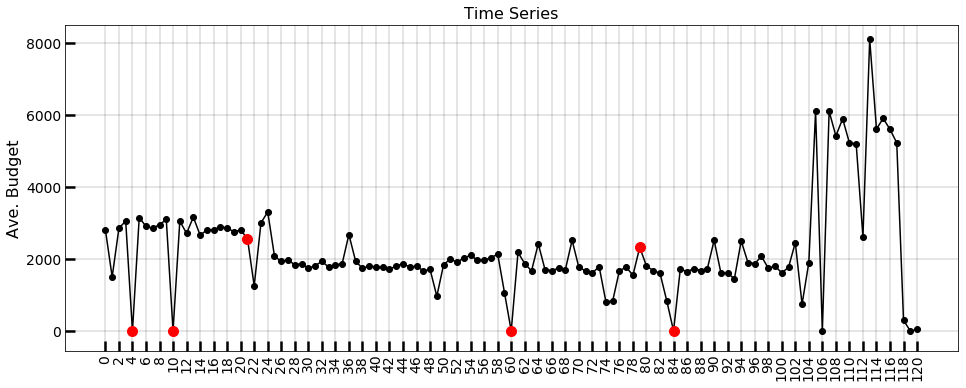

In [61]:
plt.figure(figsize=(16,6))
plt.cla()
plt.plot(t, time_series,'k-o', zorder=-1)
plt.scatter(t[master_flags[location_of_interest]], time_series.values[master_flags[location_of_interest]],
            c='r', s=100, zorder=2);
#plt.plot(t, abs(test[location_of_interest]),'r-o')
#plt.plot(t, test[location_of_interest],'g-o')
#plt.plot(t, trend_test[location_of_interest],'g')
#plt.plot([0,120],[1.5*test[location_of_interest].std(),1.5*test[location_of_interest].std()],'b')
plt.xticks(ticks=t[::2], rotation='vertical');
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.ylabel('Ave. Budget', fontsize=16)
plt.title('Time Series', fontsize=16);
plt.grid(linewidth=0.2)

In [24]:
#find_zeros(time_series.values)
#time_series.values[56]

In [46]:
master_period[location_of_interest]

3

In [47]:
pd.DataFrame(data=np.array([master_flags[location_of_interest],master_types[location_of_interest]]).T,
            columns=['Flag', 'Type'])

,Flag,Type
0,0,decrease
1,1,increase
2,3,season
3,4,decrease
4,9,increase
5,10,decrease
6,15,increase
7,18,decrease
8,19,increase
9,26,decrease


In [43]:
#master_flags[location_of_interest]

In [44]:
#master_types[location_of_interest]

In [45]:
test[11].anomaly_type.nunique()

1